In [1]:
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading a document and preprocess using tika

In [40]:
import tika
from tika import parser
from Levenshtein import distance as levenshtein_distance
import re


def read_file(fileName):
    PDF_Parse = parser.from_file(fileName)
    text = PDF_Parse['content']
    return text



def split_pages( input_text=""):
    
    no_newlines = input_text.strip("\n")  # remove leading and trailing "\n"
    
    re_page = re.compile(r"\n{3,}") 
    split_text = re_page.split(no_newlines)  # regex splitting
    
    
    # p.strip() == True if paragraph has other characters than whitespace
    pages = [p.strip("\n") for p in split_text if p.strip()]

    return pages


def remove_repeating_paragraphs(pages):
    pages = [page.split("\n\n") for page in pages]
    for page_index in range(len(pages)):
        pages[page_index] = [paragraph.strip().replace("\n"," ").replace("  "," ") for paragraph in pages[page_index] if paragraph.strip() and len(paragraph.split()) > 3]
    page =0 
    while page <len(pages):
        paragraph = 0
        while paragraph < len(pages[page]):
            repeating = [(page, paragraph)]
            for i in range(page+1, len(pages)):
                for j in range(len(pages[i])):
                    dist = levenshtein_distance(pages[i][j], pages[page][paragraph]) 
                    if dist < len(pages[i][j])/5 or dist < 5:
                        repeating.append((i,j))
        
                        
            if len(repeating) > len(pages)/12:
                print("removing :", pages[page][paragraph] ," with ", len(repeating), "occurences")
                for pair in repeating[::-1]:
                    pages[pair[0]].pop(pair[1])
            else:
                paragraph+=1
        page+=1
                
    return pages

def clean_pages(pages):
    for i in range(len(pages)):
        for j in range(len(pages[i])):
            p = re.sub(r'http\S+', '', pages[i][j])
            p = re.sub(r'[^a-zA-Z0-9.]', ' ', p) 
            p = re.sub(r' {3,}',' ', p)
            p = p.strip()
            p = p.lower()
            pages[i][j] = p
    return pages



def concat_paragraphs(pages):
    paragraphs = []
    for page in pages:
        paragraphs+= page
    return paragraphs

def correct_paragraphs(pages):
    paragraphs = []
    corrected_paragraphs = []
    
    #Sometimes a paragraphs continue in the other block in the case of a lack a space
    #So if it's not the end of the sentence we concatenate both blocks
    i = 0
    while i < len(paragraphs):
        paragraphs[i] = paragraphs[i]
        corrected_paragraphs.append(paragraphs[i])
        while paragraphs[i][-1] not in [";", ".", "?","!",":"] and i < len(paragraphs) - 1 and len(paragraphs[i].split() > 9):
            i+=1
            corrected_paragraphs[-1] = corrected_paragraphs[-1] + " " + paragraphs[i]
        i+=1
    return corrected_paragraphs
    
    
def remove_stop_words(pages, threshold = 0.7):
    unique_words = list(set(" ".join([" ".join(p) for p in pages ]).replace("."," ").replace("  "," ").split(" ")))
    word_count = {}

    for i in range(len(unique_words)):
        word_count[unique_words[i]] = 0
        for page in pages:
            for paragraph in page:
                if unique_words[i] in paragraph.split():
                    word_count[unique_words[i]] +=1
    print(word_count)
    threshold *= len(pages)
    print(threshold)
    for word in unique_words:
        if word_count[word] > threshold:
            print("deleting : ", word ,word_count[word])
            for page_index in range(len(pages)):
                for para_index in range(len(pages[page_index])):
                    pages[page_index][para_index] = " ".join([a for a in pages[page_index][para_index].split() if a != word])


    return pages




def extract_text(fileName):
    
    text = read_file(fileName)
    print("File Loaded")
    pages = split_pages(text)
    print("Removing Repeating paragraphs")
    pages = remove_repeating_paragraphs(pages)
    print("Removing stop words and common words")
    pages = clean_pages(pages)
    pages = remove_stop_words(pages)
    paragraphs = concat_paragraphs(pages)
    #print("Correcting paragraphs")
    #paragraphs = correct_paragraphs(pages)
    print("Extracted")
    return(paragraphs)
docs = extract_text("/Users/SB6282engie.com/Documents/Policy documents/Bristol/One City Climate Strategy.pdf")

File Loaded
Removing Repeating paragraphs
removing : Bristol One City Climate Strategy A strategy for a carbon neutral, climate resilient Bristol by 2030 1  with  74 occurences
removing : 2. Introduction and approach  with  7 occurences
removing : We know that we need to make fundamental changes to reach our 2030 goals. Based on the evidence that we have in 2020, we anticipate this will include actions such as:  with  10 occurences
removing : Engagement, culture  and inclusion  with  10 occurences
removing : National and regional action and city leadership  with  10 occurences
removing : Our journey to 2030  with  10 occurences
Removing stop words and common words
{'': 0, 'frameworks': 3, 'themes': 5, 'workplace': 1, 'report': 6, 'ideas': 1, 'enabling': 15, 'intense': 2, 'significantly': 8, 'fundamental': 4, 'depend': 1, 'opening': 1, 'expenditure': 3, 'distribution': 12, 'massive': 1, 'effects': 2, '000ktco2e': 2, 'awarded': 1, 'modal': 3, 'making': 7, 'legislation': 4, 'bristol': 171

In [41]:
docs

['resilient 2030',
 'foreword one environmental sustainability board',
 'facing emergency. act now reduce direct indirect net zero. prepare adapt deal projected impacts change.',
 'one plan committed becoming resilient 2030.',
 'achieve over next decade radically rethink how live work invest city.',
 'action regionally nationally internationally.',
 'provides opportunity take collaborative inclusive citywide approach make fair transition.',
 'environmental sustainability board proud lead transition city. representing range organisations come together set out shared vision strategy.',
 'given strong history delivering action excited work hand hand across continue lead way. move faster than national average learning other cities journey.',
 'sets vision where 2030 based sound science. would like thank colleagues advisory committee their review challenge evidence bristol.',
 'recognise achieving vision not easy. there entrenched market wider forces existing fossil fuel dependent consumpti

# Coreference resolution using spacy's neuralcoref

In [42]:
#Resolve coreferences
import spacy 
import neuralcoref

nlp = spacy.load('en_core_web_sm')
nlp.max_length *=2
neuralcoref.add_to_pipe(nlp)
full_doc = " <cut_here> ".join(docs)
doc_coref_resolved= nlp(full_doc)._.coref_resolved
doc_coref_resolved = doc_coref_resolved.split(" <cut_here> ")

# Bert CTM

In [43]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk

In [44]:

documents = doc_coref_resolved
sp = WhiteSpacePreprocessing(documents, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()
tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v1")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:

ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=4, num_epochs=700, reduce_on_plateau = True)
ctm.fit(training_dataset, verbose = True) # run the model


Settings: 
                   N Components: 4
                   Topic Prior Mean: 0.0
                   Topic Prior Variance: 0.75
                   Model Type: prodLDA
                   Hidden Sizes: (100, 100)
                   Activation: softplus
                   Dropout: 0.2
                   Learn Priors: True
                   Learning Rate: 0.002
                   Momentum: 0.99
                   Reduce On Plateau: True
                   Save Dir: None


Epoch: [286/700]	 Seen Samples: [236236/578200]	Train Loss: 92.70619951668432	Time: 0:00:01.100659: : 286it [03:13,  1.24it/s]

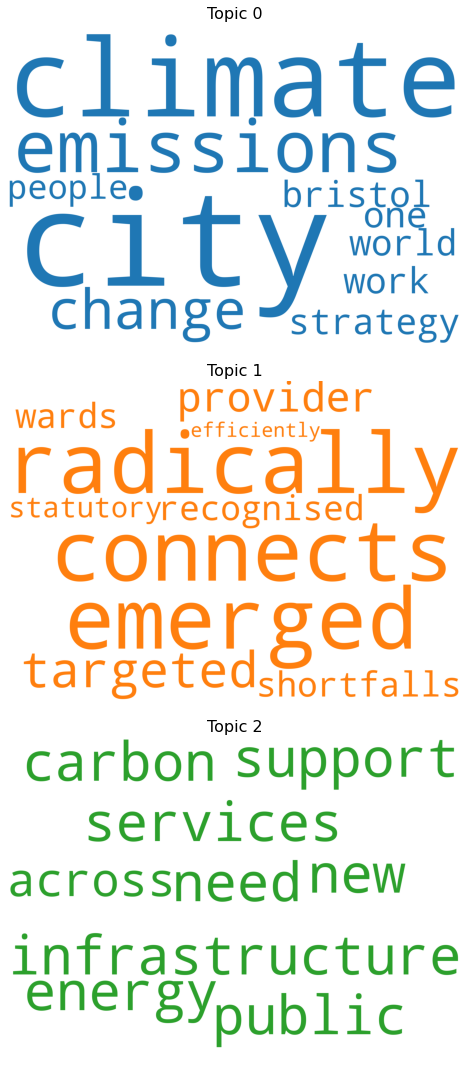

In [27]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols *= 10

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab12',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ctm.get_topic_lists(10)

fig, axes = plt.subplots(3, 1, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate(" ".join(topics[i]))
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [19]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.43it/s]
/Users/SB6282engie.com/opt/anaconda3/envs/py37NLP/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols *= 10

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab12',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ctm.get_topic_lists(10)

fig, axes = plt.subplots(20, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate(" ".join(topics[i]))
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

# LDA Model

In [ ]:
#Tokenize by words
from gensim import corpora
from gensim.models import ldamodel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import wordnet
from gensim.models.coherencemodel import CoherenceModel
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(i)
        # add tokens to list
        texts.append(tokens)
    return texts
clean_docs= preprocess_data(doc_by_sent)

In [ ]:
#Compute bigrams, trigrams, quadgrams
import gensim
bigram = gensim.models.Phrases(clean_docs, min_count=5, threshold=90) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_docs], threshold=80)
quadgram = gensim.models.Phrases(trigram[clean_docs], threshold=70)
# Faster way to get a sentence clubbed as a trigram/bigram/quadgram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
quadgram_mod = gensim.models.phrases.Phraser(quadgram)


import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def make_quadgrams(texts):
    return [quadgram_mod[trigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(clean_docs)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_bigrams)
data_words_quadgrams = make_quadgrams(data_words_trigrams)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_quadgrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:10])

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dictionary,doc_term_matrix = prepare_corpus(data_lemmatized)

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    print("Start compute")
    model_list = []
    s1=time.time()
    for num_topics in range(start, stop, step):
        s=time.time()
        print(int((num_topics-start)/step), " / ", len(range(start, stop, step)),"last step took ", s-s1, "s")
        s1=s
        # generate LSA model
        model = ldamodel.LdaModel(corpus=doc_term_matrix,id2word=dictionary, num_topics = num_topics)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    print('highest coherence for : ', np.argmax(coherence_values)*step + start)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    return np.argmax(coherence_values)*step + start
start,stop,step=1,30,1
num_topics = plot_graph(data_lemmatized,start,stop,step)

In [ ]:
def compute_coherence_values(doc_term_matrix, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=doc_term_matrix,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 30
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.1))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.1))
beta.append('symmetric')
# Validation sets
num_of_docs = len(data_lemmatized)
corpus_sets = [gensim.utils.ClippedCorpus(data_lemmatized, num_of_docs*0.75), data_lemmatized]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=len(topics_range) * len(alpha) * len(beta))


    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=doc_term_matrix, dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

df = pd.read_csv('lda_tuning_results.csv')
df

bestdf = pd.DataFrame(columns = df.columns)
for i in range(2,30):
    tmp = df[df["Topics"] == i].reset_index(drop= True)
    arg = tmp["Coherence"].argmax()
    bestdf = pd.concat([bestdf, tmp.loc[arg:arg,]]).reset_index(drop = True)
bestdf

plt.plot(range(2,30), bestdf["Coherence"])
plt.xlabel("number of topics")
plt.ylabel("coherence")

In [ ]:
df = pd.read_csv('lda_tuning_results.csv')
bestdf = pd.DataFrame(columns = df.columns)
for i in range(2,30):
    tmp = df[df["Topics"] == i].reset_index(drop= True)
    arg = tmp["Coherence"].argmax()
    bestdf = pd.concat([bestdf, tmp.loc[arg:arg,]]).reset_index(drop = True)

plt.plot(range(2,30), bestdf["Coherence"])
plt.xlabel("number of topics")
plt.ylabel("coherence")    
bestdf


In [ ]:
lda = ldamodel.LdaModel(corpus=doc_term_matrix,id2word=dictionary, num_topics = 12, alpha= 'asymmetric', eta=0.91)

In [ ]:
from pprint import pprint
# Print the Keyword in the 12 topics
pprint(lda.print_topics())
doc_lda = lda[doc_term_matrix]

In [ ]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(doc_by_sent, show_progress_bar=True)


umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = [lda[doc_term_matrix[i]][0][0] for i in range(len(doc_term_matrix))]

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='hsv_r')
plt.colorbar()

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=doc_term_matrix, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

In [ ]:
cols

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
cols += cols[0:2]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab12',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(num_topics=12,formatted=False)

fig, axes = plt.subplots(6, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# LSA with lemmatization/sense2vec embedding

In [ ]:
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import wordnet
from gensim.models.coherencemodel import CoherenceModel
def preprocess_data(doc_set):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    lemmatizer = wordnet.WordNetLemmatizer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(i)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop and not i.isdigit() and len(i)>2]
        # stem tokens
        stemmed_tokens = [lemmatizer.lemmatize(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
clean_docs= preprocess_data(docs)

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dic,matrix = prepare_corpus(clean_docs)

In [ ]:
import time
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    print("Start compute")
    model_list = []
    s1=time.time()
    for num_topics in range(start, stop, step):
        s=time.time()
        print(int((num_topics-start)/step), " / ", len(range(start, stop, step)),"last step took ", s-s1, "s")
        s1=s
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dic, matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    print('highest coherence for : ', np.argmax(coherence_values))
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
start,stop,step=1,30,1
plot_graph(clean_docs,start,stop,step)

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = words)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=7))
    return lsamodel
number_of_topics=16
lsamodel = create_gensim_lsa_model(clean_docs, number_of_topics, dic)

In [ ]:
SDG=["Poverty", "hunger", "health","education","gender equality","water","energy","economic","innovation infrastructure","equality", "sustainable","production","climate","life", "peace"]





In [ ]:
def extract_words_topics(lsamodel, number_of_topics):
    L=[]
    for i in range(number_of_topics):
        if len(L) == 0 or len(L[-1])>0:
            L.append([])
        topic=lsamodel.show_topic(i)
        for j in range(len(topic)):
            if topic[j][1]>0:
                L[-1].append(s2v.get_best_sense(topic[j][0]))
    return L
word_topics=extract_words_topics(lsamodel, number_of_topics)

In [ ]:
word_topics,lsamodel.show_topic(0)

In [ ]:
from sense2vec import Sense2Vec 
import numpy as np
s2v = Sense2Vec().from_disk("/Users/SB6282engie.com/Downloads/s2v_old")
similarity_matrix=np.zeros((len(SDG), len(word_topics)))
for i in range(len(SDG)):
    SDGlist = SDG[i].split(" ")
    for j in range(len(SDGlist)):
        SDGlist[j] = s2v.get_best_sense(SDGlist[j])
    for j in range(len(word_topics)):
        similarity_matrix[i,j] = s2v.similarity(SDGlist, word_topics[j])

In [ ]:
topics_names = [SDG[i] for i in np.argmax(similarity_matrix, axis=0)]
for i in range(len(topics_names)):
    print(i, topics_names[i], word_topics[i])

# HDBSCAN with UMAP and BERT Embedding

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(docs, show_progress_bar=True)

In [ ]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [ ]:
cluster.labels_

In [ ]:
clustered = {}
for i in np.unique(cluster.labels_):
    clustered[i] = np.where(cluster.labels_ == i)
    print(i, clustered[i])

In [ ]:
for key in clustered:
    
    print(key)
    for page in clustered[key][0]:
        print("Still on ", key)
        print(page)
        print(docs[page])
    print("_________________________")

In [ ]:
clustered[-1]

# BERT Topic

In [39]:
sp = WhiteSpacePreprocessing(doc_coref_resolved, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_lemmatized = lemmatization(preprocessed_documents, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [40]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=40, n_gram_range=(1,3), verbose=True)
topics, _ = topic_model.fit_transform(preprocessed_documents)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

2022-02-10 15:54:46,116 - BERTopic - Transformed documents to Embeddings
2022-02-10 15:54:48,601 - BERTopic - Reduced dimensionality with UMAP
2022-02-10 15:54:48,636 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [41]:
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name
0,-1,518,-1_bristol_city_carbon_infrastructure
1,0,206,0_climate_bristol_city_change
2,1,91,1_strategy_city_need_organisations


In [ ]:

topic_model.get_topic(0)

In [ ]:
topic_model.visualize_topics()